In [8]:
import pickle
import numpy as np
import lzma
import scipy.signal
import tensortools as tt
import pickle
import matplotlib.pyplot as plt
import multiprocessing

In [15]:
np.__version__

'1.23.5'

In [16]:
tt.__file__

'/Volumes/Files_Portable/Neuro/NetworkGeneration/tensortools/tensortools/__init__.py'

In [5]:
def calTCA(paramdict):
    vec_lst = VecbyParm_withGaussian_dic(param)
    ensemble = tt.Ensemble(fit_method="cp_als")
    ensemble.fit(vec_lst, ranks=range(1, 11), replicates=4)
    savefile_tca(ensemble, paramdict)
    return 0

def add_gaussian_kernel(input_vector, kernel_size, sigma):

    # Define the Gaussian kernel
    kernel = scipy.signal.gaussian(kernel_size, sigma)
    
    # Initialize the result vector with zeros as floating-point numbers
    result_vector = np.zeros(len(input_vector), dtype=float)
    
    # Iterate through the input vector
    for i, value in enumerate(input_vector):
        if value == 1.0:
            # Add the Gaussian kernel to the result vector centered around the current index
            start_idx = max(0, i - (kernel_size // 2))
            end_idx = min(len(input_vector), i + (kernel_size // 2) + 1)
            result_vector[start_idx:end_idx] += kernel[
                (kernel_size // 2) - (i - start_idx) : (kernel_size // 2) + (end_idx - i)
            ]
    
    return result_vector

sigma_my = 1.0 / 0.025
kernel_size_my = int(sigma_my) * 5 * 2 + 1

def FiletoVec(name):
    with lzma.open("./savedoutput/" + name + ".xz", "rb") as fp:
        outsaved = pickle.load(fp)
    vec_space = 0.025
    spike_mat = np.zeros((len(outsaved), int(10000/vec_space)))
    for i in range(len(outsaved)):
        for n in range(len(outsaved[i])):
            j = int(outsaved[i][n]/vec_space)
            spike_mat[i, j] = 1
    return spike_mat

def FiletoVec_param(NetworkType, n, model_id, input_idx, MeanDelay, stdDelay, n_run):
    CellType = "point"
    name = str(NetworkType) + '_' + str(CellType) + '_layercount' + str(n) + '_model' + str(model_id) + '_input' + str(input_idx) + '_stddelay' + str(stdDelay) + '_meandelay' + str(MeanDelay) + '_nrun' + str(n_run)
    return FiletoVec(name)

def VecbyParm(NetworkType, n, model_id, input_idx, MeanDelay, stdDelay):
    vec_lst = []
    for n_run in np.arange(0, 10, 1):
        vec_lst.append(FiletoVec_param(NetworkType, n, model_id, input_idx, MeanDelay, stdDelay, n_run))
    return np.stack(vec_lst)

def VecbyParm_withGaussian(NetworkType, n, model_id, input_idx, MeanDelay, stdDelay):
    noguas = VecbyParm(NetworkType, n, model_id, input_idx, MeanDelay, stdDelay)
    result_3d = np.apply_along_axis(add_gaussian_kernel, axis=2, arr=noguas, kernel_size = kernel_size_my, sigma = sigma_my)
    return result_3d

def VecbyParm_withGaussian_dic(paramdict):
    NetworkType, n, model_id, input_idx, MeanDelay, stdDelay = paramdict['NetworkType'], paramdict['n'], paramdict['model_id'], paramdict['input_idx'], paramdict['MeanDelay'], paramdict['stdDelay']
    noguas = VecbyParm(NetworkType, n, model_id, input_idx, MeanDelay, stdDelay)
    result_3d = np.apply_along_axis(add_gaussian_kernel, axis=2, arr=noguas, kernel_size = kernel_size_my, sigma = sigma_my)
    return result_3d

def savefile_tca(dataobj, paramdict):
    NetworkType, cellcount, model_id, input_idx, meandelay, stddelay = paramdict['NetworkType'], paramdict['n'], paramdict['model_id'], paramdict['input_idx'], paramdict['MeanDelay'], paramdict['stdDelay']
    with open('./TCAProcessing/'+ NetworkType + "_cellcount" + str(cellcount) + "_meandelay" + str(meandelay) + "_stddelay" + str(stddelay) + "_modelid" + str(model_id) + "_inputid" + str(input_idx) + "_spectral.pkl",'wb') as f: 
        pickle.dump(dataobj, f)
    with open('./TCACounter/'+ str(paramdict['counter'])+".pkl",'wb') as f: 
        pickle.dump([], f)


    
        

In [6]:
paramlist = []
counter = 0
for networktype in ['FeedForward', 'ScaleFree', 'SmallWorld']:
    for cellcount in [30, 50, 60]:
        for modelid in range(10):
                for inputid in range(10):
                    for MeanDelay_noround in np.arange(2, 3.01, 0.2):
                        MeanDelay = np.round(MeanDelay_noround,1)
                        for stdDelay_noround in np.arange(0, 1.01, 0.05):
                            stdDelay = np.round(stdDelay_noround,2)
                            param = {'NetworkType': networktype, 'n': cellcount, 'model_id': modelid, 'input_idx': inputid, 'MeanDelay': MeanDelay, 'stdDelay': stdDelay, 'counter': counter}
                            paramlist.append(param)
                            counter += 1

In [5]:
len(paramlist)

113400

In [6]:
paramlist[3*12600 + 1]

{'NetworkType': 'ScaleFree',
 'n': 30,
 'model_id': 0,
 'input_idx': 0,
 'MeanDelay': 2.0,
 'stdDelay': 0.05,
 'counter': 37801}

In [1]:
# calTCA(paramlist[3*12600 + 1])

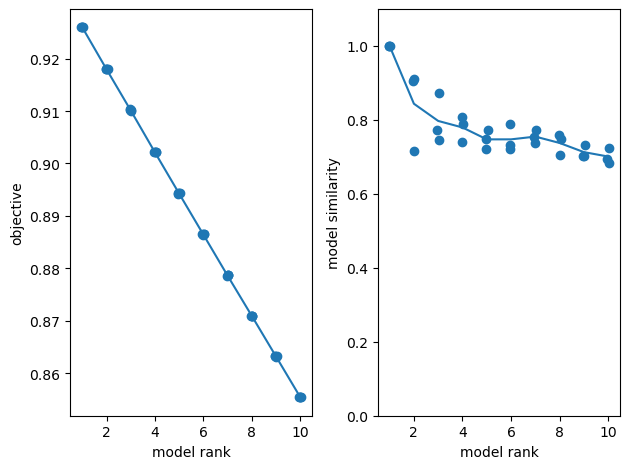

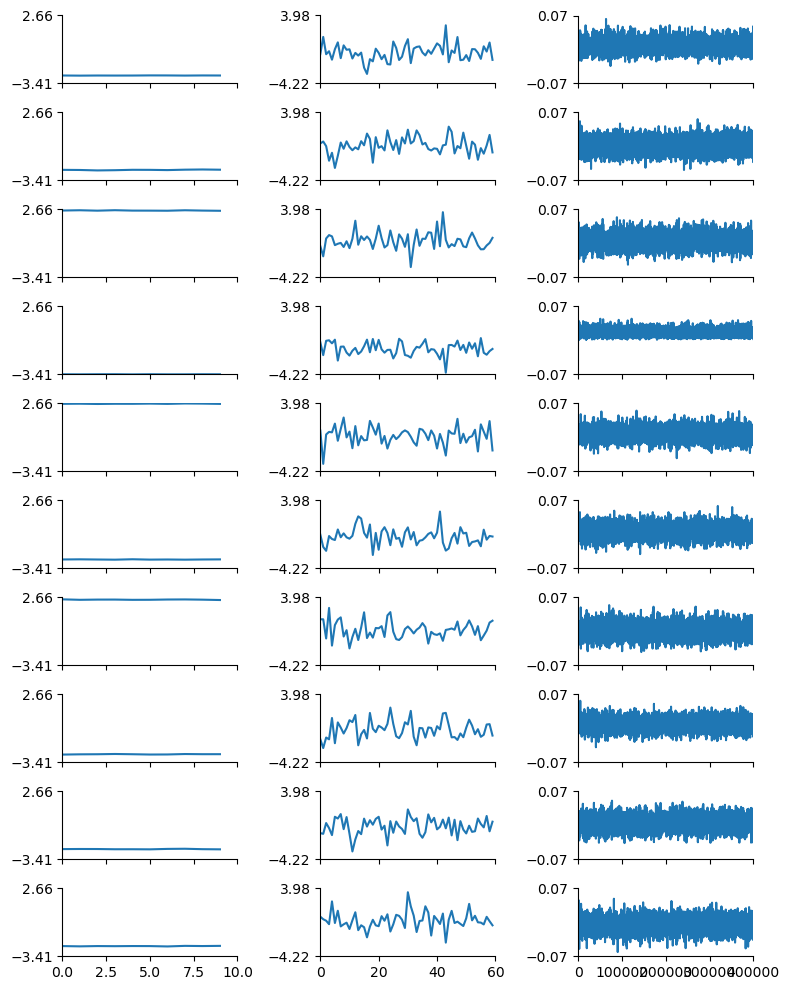

In [7]:
import matplotlib.pyplot as plt
import pickle

# Function definition to reload the TCA data
def reloadfile_tca(paramdict):
    NetworkType, cellcount, model_id, input_idx, meandelay, stddelay = paramdict['NetworkType'], paramdict['n'], paramdict['model_id'], paramdict['input_idx'], paramdict['MeanDelay'], paramdict['stdDelay']
    filename = f'./TCAProcessing/{NetworkType}_cellcount{cellcount}_meandelay{meandelay}_stddelay{stddelay}_modelid{model_id}_inputid{input_idx}_spectral.pkl'
    with open(filename, 'rb') as f: 
        output = pickle.load(f)
    return output

# Load the data using the provided parameters (assuming paramlist is defined)
ensemble = reloadfile_tca(paramlist[3*12600 + 1])

# Plotting the ensemble analysis results
fig, axes = plt.subplots(1, 2)
tt.plot_objective(ensemble, ax=axes[0])  # plot reconstruction error as a function of num components
tt.plot_similarity(ensemble, ax=axes[1]) # plot model similarity as a function of num components
fig.tight_layout()

# Plot the low-dimensional factors for an example model
num_components = 10
replicate = 0

# Check if the factors method exists in ensemble
if hasattr(ensemble, 'factors'):
    factors = ensemble.factors(num_components)
    if replicate < len(factors):
        tt.plot_factors(factors[replicate])  # plot the low-dimensional factors
    else:
        print(f"No replicate {replicate} for num_components {num_components}")
else:
    print("The ensemble object does not have a 'factors' method.")

plt.show()
